# Gerando informações para a apresentação

In [10]:
# python standard
import os
import time
import re
from multiprocessing import Pool, TimeoutError
from datetime import datetime

# third-party
import numpy as np
import pandas as pd
import scipy.constants as cte
from scipy.integrate import simps
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
from scipy.stats import norm, skewnorm
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from scipy.special import legendre, expit
from scipy.signal import gaussian

# locals
from core.utilidades import *

In [19]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('mestrado')

In [12]:
# ## Constantes físicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')
au_v = cte.value('atomic unit of electric potential')
au_ef = cte.value('atomic unit of electric field')
me = cte.value('electron mass')
c = cte.value('speed of light in vacuum')
q = cte.value('elementary charge')
hbar_ev = cte.value('Planck constant over 2 pi in eV s')
hbar = cte.value('Planck constant over 2 pi')
h = cte.value('Planck constant')
ev = cte.value('electron volt')
# outras relacoes de interesse
au2ang = au_l / 1e-10
au2ev = au_e / ev
hbar_au = 1.0
me_au = 1.0

# onda plana
grid_tempo = np.linspace(0.0, 2.1739442773545673e-14, 20)
alias = {
    'Solucao Analitica': '',
    'Pseudo-Espectral': 'pe',
    'Crank-Nicolson': 'cn',
    'Runge-Kutta': 'rk'
}
metodos = list(alias.keys())


parametros = {
    'onda_plana_parametro_bom': {
        'L': 100.0,
        'N': 1024,
        'dt': 1e-18
    },
    'onda_plana_parametro_ruim': {
        'L': 850.0,
        'N': 256,
        'dt': 1e-16
    }
}

# Gerando fotocorrente

In [13]:
# dataframe de pandas com valores utilizados para calculos
device = pd.DataFrame()

N = 1024  # tamanho padrao do grid
L = 1000.0  # tamanho padrao do sistema em angstrom
dt = 1e-17  # incremento de tempo padrao em segundos
device['z_ang'] = np.linspace(-L/2, L/2, N)  # malha espacial em angstrom

In [14]:
def algaas_gap(x):
    """Retorna o gap do material ja calculado em funcao da fracao de Aluminio
    utilizamos os valores exatos utilizados pelos referidos autores

    Params
    ------
    x : float
        a fracao de aluminio, entre 0 e 1

    Returns
    -------

    O gap em eV
    """
    if x == 0.2:
        return 0.0
    elif x == 0.4:
        return 0.185897
    return -0.185897


def algaas_meff(x):
    """Retorna a massa efetiva do AlGaAs em funcao da fracao de Aluminio
    assim como os referidos autores, utilizamos a massa efetiva do 
    eletron no GaAs ao longo de todo o material

    Params
    ------
    x : float
        a fracao de aluminio, entre 0 e 1

    Returns
    -------

    A massa efetiva do eletron no AlGaAs
    """
    return 0.067


def x_shape(z):
    """Utilizamos a concentracao de Aluminio para determinar o perfil do
    potencial

    Params
    ------

    z : float
        posicao no eixo z em angstrom

    Returns
    -------

    A concentracao de Aluminio na posicao informada
    """
    # concentracoes e larguras do sistema
    xd = 0.2  # concentracao no espaco entre poco e barreira
    xb = 0.4  # concentracao na barreira
    xw = 0.0  # concentracao no poco
    wl = 50.0  # largura do poco em angstrom
    bl = 50.0  # largura da barreira em angstrom
    dl = 40.0  # espacao entre poco e barreira em angstrom

    if np.abs(z) < wl/2:
        return xw
    elif np.abs(z) < wl/2+dl:
        return xd
    elif np.abs(z) < wl/2+dl+bl:
        return xb
    return xd

In [15]:
device['x'] = device['z_ang'].apply(x_shape)
device['v_ev'] = device['x'].apply(algaas_gap)
device['meff'] = device['x'].apply(algaas_meff)

pb = list(device['v_ev']).index(0.185897)  # pontos antes do dispositivo
pa = N-1-pb  # pontos depois do dispositivo

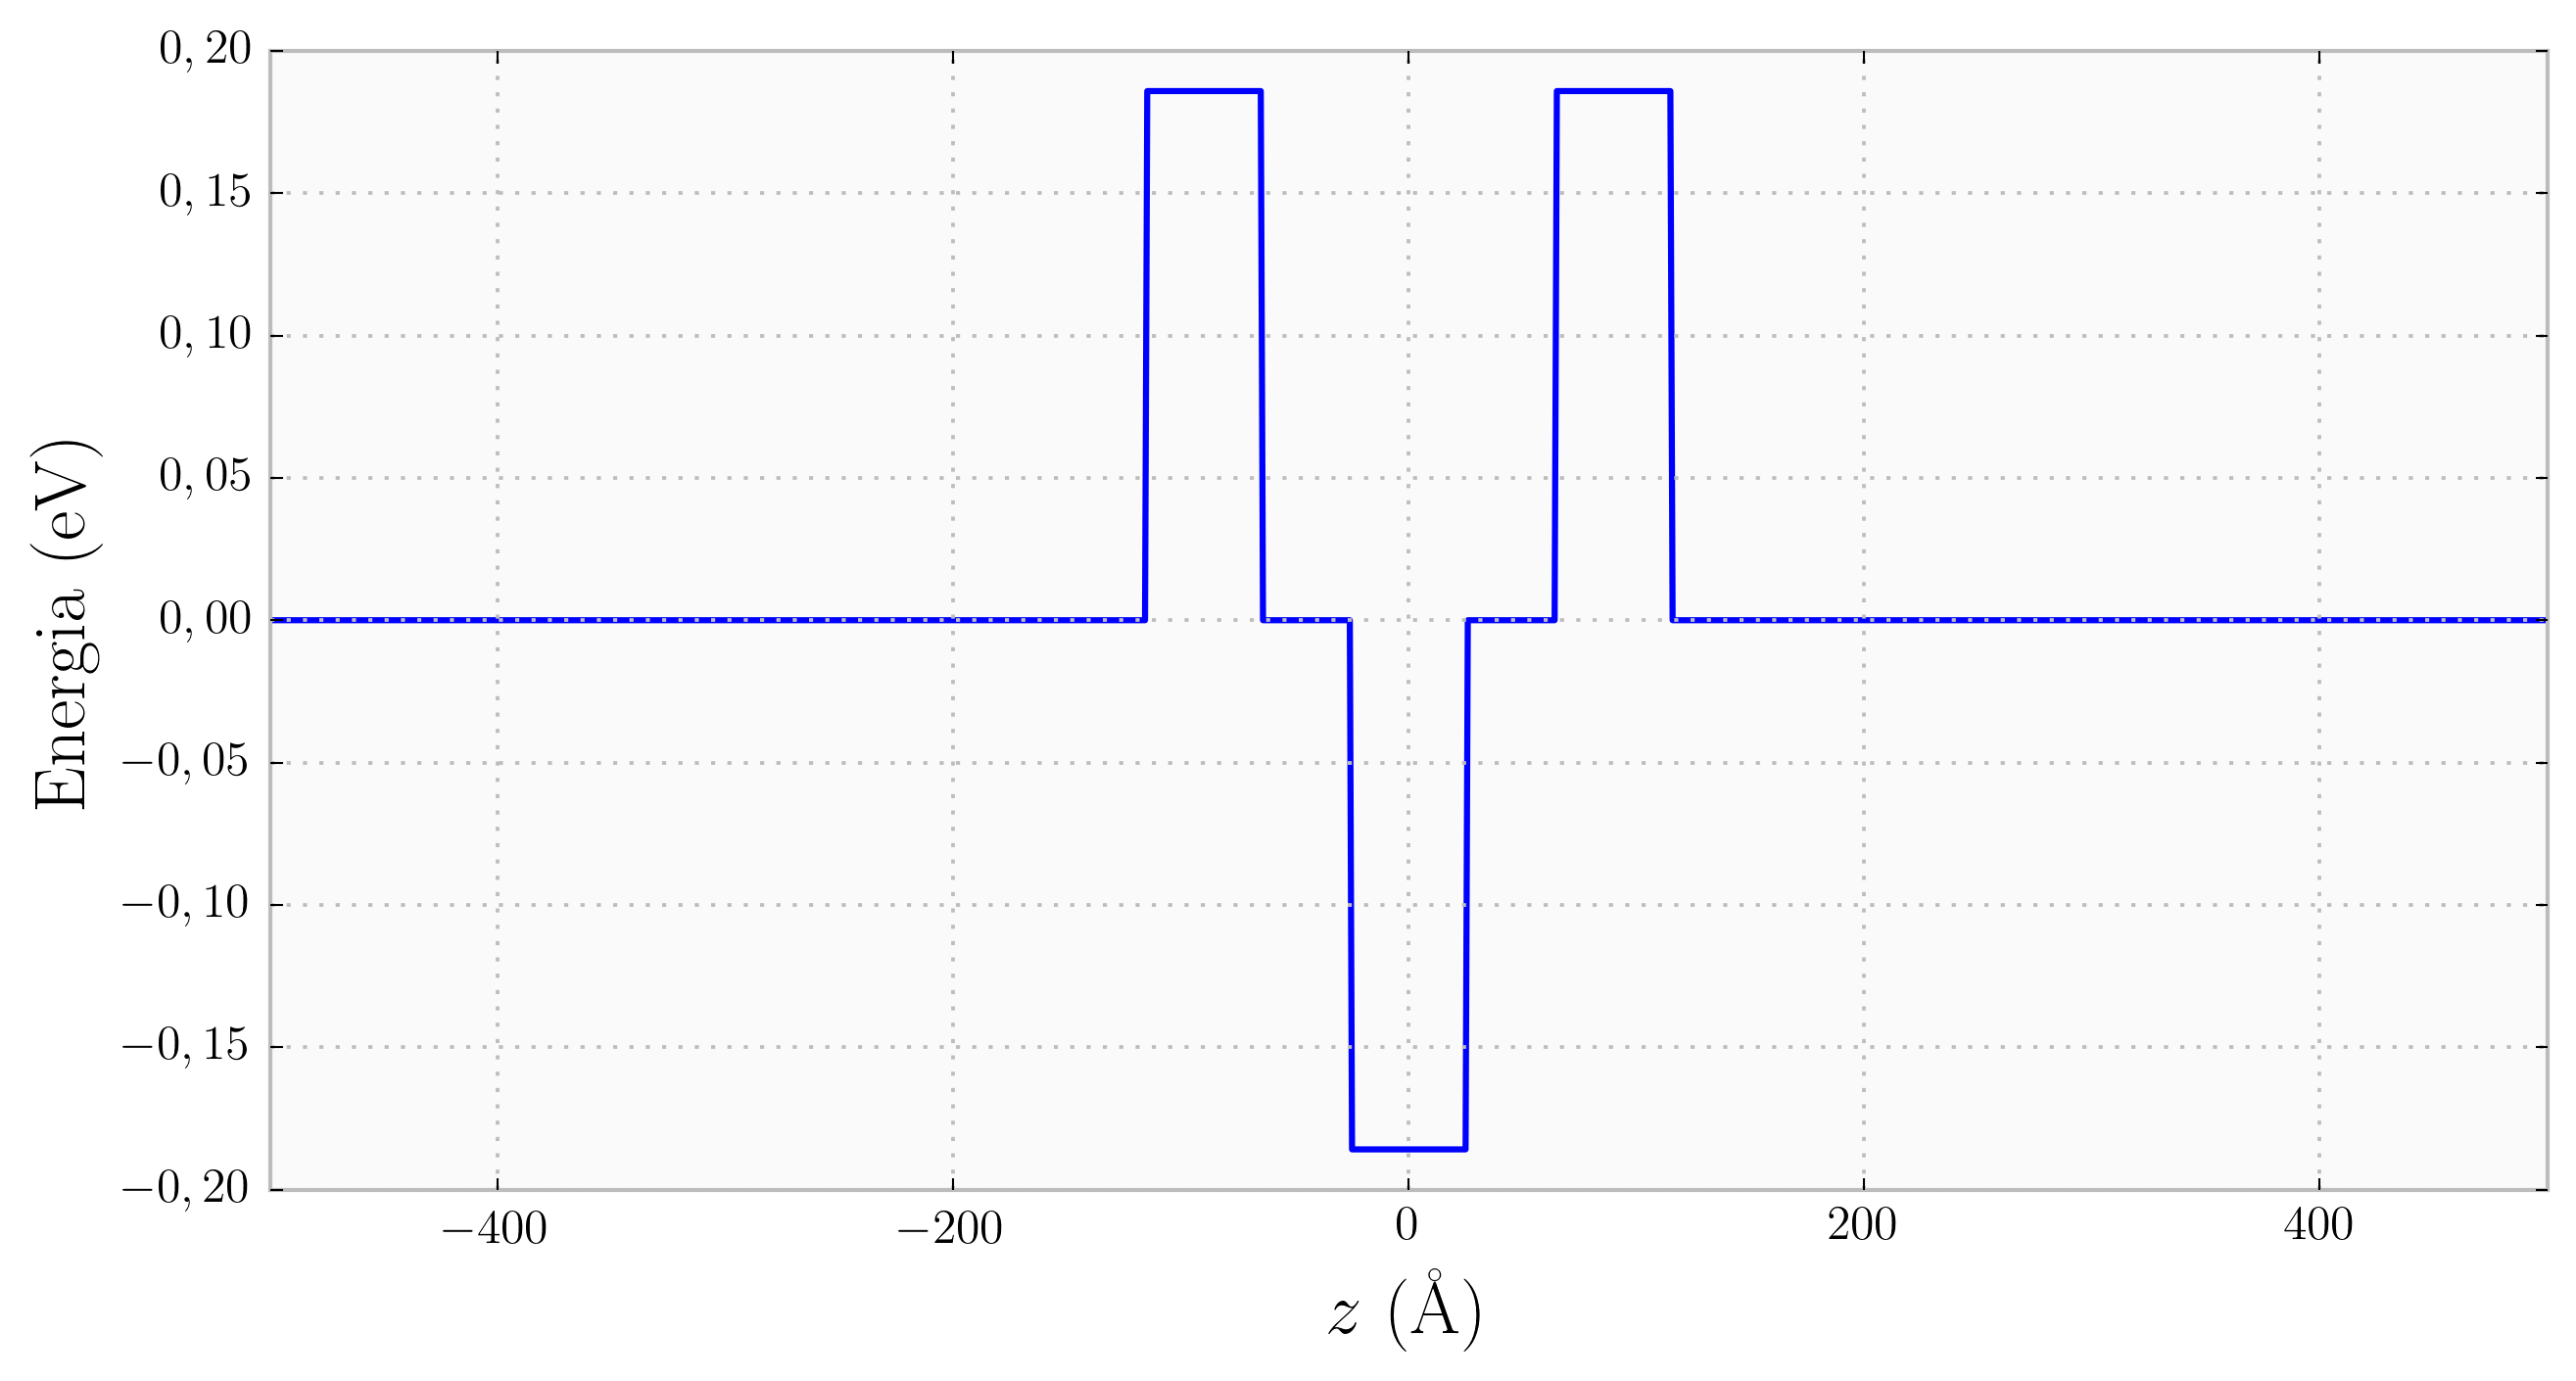

In [16]:
ax = device.plot(x='z_ang', y='v_ev', grid=True, legend=False)
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
plt.savefig('figuras/poco_dupla_barreira_potencial_simples.png')

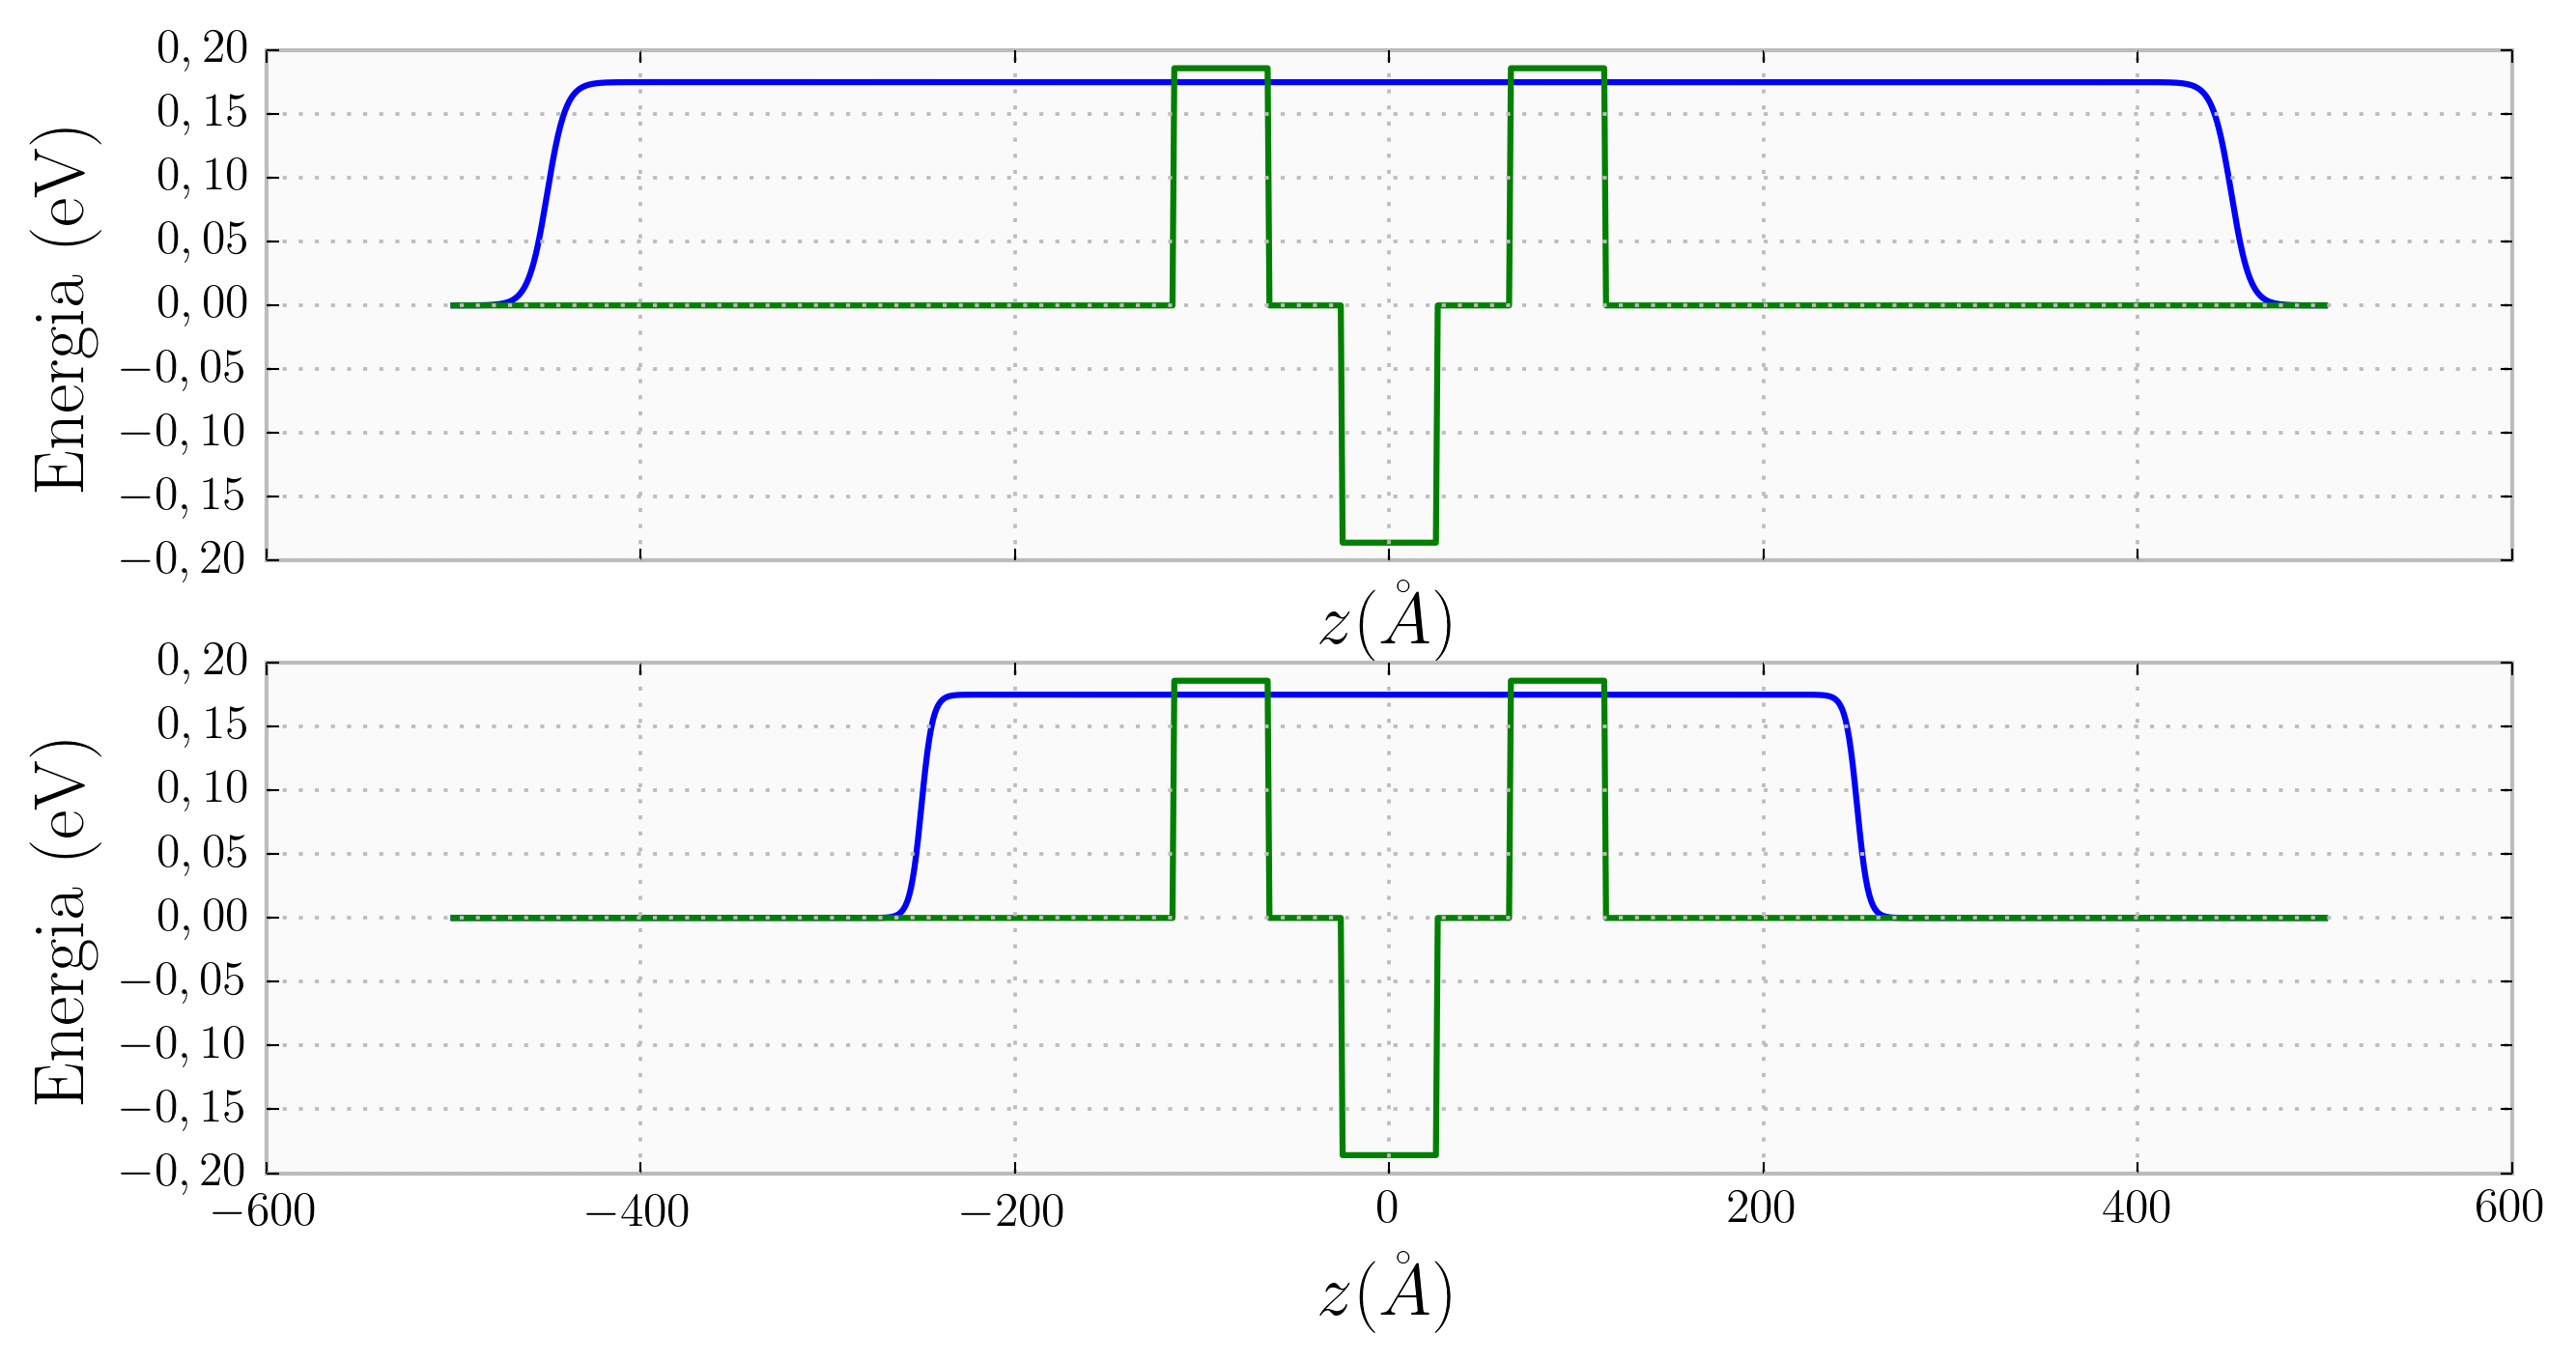

In [28]:
z = np.linspace(-L/2,L/2,N)
killer_1 = 0.175 * np.array([min(l,r) for l,r in zip(expit((450-z)/5), expit((z+450)/5))])
killer_2 = 0.175 * np.array([min(l,r) for l,r in zip(expit((250-z)/3), expit((z+250)/3))])

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_xlabel(r'$z (\AA)$')
ax1.set_ylabel(r'Energia (eV)')
ax1.plot(device.z_ang, killer_1)
ax1.plot(device.z_ang, device.v_ev)
# ax1.xaxis.set_minor_locator(MultipleLocator(50))
# ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
# ax1.set_ylim([-0.05, 1.05])
# ax1.grid(which = 'minor')

ax2.set_xlabel(r'$z (\AA)$')
ax2.set_ylabel(r'Energia (eV)')
ax2.plot(device.z_ang, killer_2)
ax2.plot(device.z_ang, device.v_ev)
# ax2.xaxis.set_minor_locator(MultipleLocator(50))
# ax2.yaxis.set_minor_locator(MultipleLocator(0.2))
# ax2.set_ylim([-0.05, 2.05])
# ax2.grid(which = 'minor')

plt.grid(True)
plt.savefig('figuras/poco_dupla_barreira_potencial_simples_com_absordedor.png')

In [7]:
bias = 5.0  # KV/cm LIGAR NO CASO DE FOTOCORRENTE
bias_v_cm = bias * 1e3
bias_v_m = 1e2 * bias_v_cm
bias_j_m = bias_v_m * q

def __constroi_bias(z):
    """constroi o potencial estatico usado como bias/vies, nao usar fora desta
    celula

    Params
    ------

    z : float
        uma posicao no grid em angstrom

    Returns
    -------

    O bias na posicao indicada
    """
    border_left = device['z_ang'].values[pb]
    border_right = device['z_ang'].values[pa]

    def f_st_ev(z): return -(z*1e-10)*(bias_j_m)/ev

    if z <= border_left:
        return f_st_ev(border_left)
    elif z >= border_right:
        return f_st_ev(border_right)
    return f_st_ev(z)


device['bias_ev'] = device['z_ang'].apply(__constroi_bias)
device['v_st_ev'] = device['v_ev']+device['bias_ev']

In [ ]:
ax = device.plot(x='z_ang', y='v_st_ev', grid=True, legend=False)
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
plt.savefig('figuras/poco_dupla_barreira_potencial_com_bias.png')

In [8]:
device['z_au'] = device['z_ang'].apply(lambda z: z / au2ang)
device['v_au'] = device['v_st_ev'].apply(lambda z: z / au2ev)
dt_au = dt / au_t

In [9]:
def solve_eigenproblem(H):
    """
    Solve an eigenproblem and return the eigenvalues and eigenvectors.
    """
    vals, vecs = np.linalg.eig(H)
    idx = np.real(vals).argsort()
    vals = vals[idx]
    vecs = vecs.T[idx]

    return vals, vecs

dev = device.copy()
dz = dev['z_au'][1]-dev['z_au'][0]
dz2 = dz**2
V = dev['v_au'].values
m = dev['meff'].values
z = dev['z_au'].values
v_ev = V*au2ev
z_ang = z*au2ang

# Desloca o potencial do Hamiltoniano por shift
sub_diag = np.zeros(N-1, dtype=np.complex_)
main_diag = np.zeros(N, dtype=np.complex_)

# constroi as diagnais da matriz, a principal e as duas semi
# principais
for i in range(N):
    try:
        main_diag[i] = (0.5/dz2)*(1.0/idf(m, i+0.5) + 1.0/idf(m, i-0.5))+(V[i])
    except:
        main_diag[i] = 0.0

    if i < N-1:
        sub_diag[i] = -(0.5/dz2)*(1.0/idf(m, i+0.5))

diagonals = [main_diag, sub_diag, sub_diag]
A = diags(diagonals, [0, -1, 1]).toarray()

res = solve_eigenproblem(A)

In [ ]:
autovalores = res[0][0:16]
res2 = interacao_inversa(z, V, m, autovalores=autovalores, remover_repetidos=False)
autovalores = np.copy(res2['autovalores'])
autovetores = np.copy(res2['autovetores'])
fig, ax = plt.subplots()
ax.plot(z_ang, v_ev, label=r"$V(z)$") 

for i, vec in enumerate(autovetores):
    vec /= np.sqrt(simps(vec*vec.conj(),z_ang))
    vec2 = 2*np.abs(vec)**2+autovalores[i]*au2ev
    ax.plot(z_ang, vec2)
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
plt.legend()
plt.savefig('figuras/poco_dupla_barreira_potencial_func_onda_tudo.png')
plt.show()    

In [ ]:
autovalores = res[0][[0,7,14]]
res2 = interacao_inversa(z, V, m, autovalores=autovalores)
autovalores = np.copy(res2['autovalores'])
autovetores = np.copy(res2['autovetores'])

In [ ]:
fig, ax = plt.subplots()
ax.plot(z_ang, v_ev, label=r"$V(z)$") 

for i, vec in enumerate(autovetores):
    vec /= np.sqrt(simps(vec*vec.conj(),z_ang))
    vec2 = 2*np.abs(vec)**2+autovalores[i]*au2ev
    ax.plot(z_ang, vec2)#, label=r'$|\psi_{}(z)|^2$'.format(i))
    ax.text(-400, autovalores[i]*au2ev+0.01, r'$|\psi_{}(z)|^2$'.format(i))
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
plt.legend()
plt.savefig('figuras/poco_dupla_barreira_potencial_func_onda.png')
plt.show()    

In [ ]:
fig, ax = plt.subplots()
ax.plot(z_ang, v_ev, label=r"$V(z)$") 

for i, vec in enumerate(autovetores[0:1]):
    vec /= np.sqrt(simps(vec*vec.conj(),z_ang))
    vec2 = vec/2+autovalores[i]*au2ev
    ax.plot(z_ang, vec2)#, label=r'$|\psi_{}(z)|^2$'.format(i))
    ax.text(-400, autovalores[i]*au2ev+0.01, r'$\psi(z,0) = \psi_{}(z)$'.format(i))
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'Energia (eV)')
plt.legend()
plt.savefig('figuras/poco_dupla_barreira_potencial_func_onda_inicial.png')
plt.show()    

In [ ]:
energy = 0.15317725752508362658
fosc=5.0
T=1e-12
fosc_j_m = fosc * 1e2 * 1e3 * q  # KV/cm -> J/m
T_au = T / au_t
iters = int(T_au / dt_au)
z_au = device.z_au.values
t_grid_au = np.linspace(0.0, T_au, iters)

psi = np.array(autovetores[0], dtype=np.complex_)
psi /= np.sqrt(simps(psi*psi.conj(), device.z_au))

meff = device['meff'].values
z_au = device['z_au'].values
dz_au = z_au[1]-z_au[0]
k_au = fftfreq(N, d=dz_au)
j_t = np.zeros(iters)

def j_p(p):
    """J=1/(2 i m*) (psi* d(psi)/dz - psi d(psi*)/dz) """
    dzp = z_au[p+1]-z_au[p-1]
    pcdp = psi[p].conj() * (psi[p+1]-psi[p-1]) / dzp
    pdpc = psi[p] * (psi[p+1].conj()-psi[p-1].conj()) / dzp
    return ((-0.5j/(meff[p])) * (pcdp-pdpc)).real

absorbing = device['z_ang'].apply(
    lambda z: min(expit((450-z)/5), expit((z+450)/5)))
absorbing = absorbing.values

z0_ang = device['z_ang'].values[0]
fosc_j = device['z_ang'].apply(lambda z: (z0_ang-z) * 1e-10 * fosc_j_m)
fosc_j = device['z_ang'].apply(lambda z: z * 1e-10 * fosc_j_m)
fosc_ev = fosc_j / ev
fosc_au = fosc_ev / au2ev
omega_au = (energy / au2ev) / hbar_au
v_au_ti = device['v_au'].values
exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / meff)
#exp_v2h = np.exp(- 0.5j * v_au_ti * dt_au)
exp_v2h = np.exp(- 1.0j * v_au_ti * dt_au)
#f_espec = - 0.5j * fosc_au * dt_au
f_espec = - 1.0j * fosc_au * dt_au

In [ ]:
j = 1
for i, t_au in enumerate(t_grid_au[0:10000]):
    if i % 10 == 0 or i == len(t_grid_au) - 1:
        fig, ax = plt.subplots()
        pot = (v_au_ti + fosc_au * np.sin(omega_au * t_au))*au2ev
        ax.plot(z_ang, pot, label=r"$V'(z)+e F_\mathrm{osc} \sin(\omega t)$") 
        ax.set_title(r"t = " + r"${}$ s".format(as_si(t_au * au_t, 2)), fontsize=16)
        ax.set_xlabel(r'$z$ (\AA)')
        ax.set_ylabel(r'Energia (eV)')
        ax.set_xlim(-600.0, 600.0)
        ax.set_ylim(-0.25, 0.2)        
        plt.savefig('apresentacao/saidas/poco_dupla_barreira_potencial_osc_{0:04d}.png'.format(j))
        plt.legend(loc='lower left')
        plt.close('all')
        j += 1

In [ ]:
sub_diag = np.zeros(N-1, dtype=np.complex_)
for i in range(N):
    if i < N-1:
        sub_diag[i] = -(0.5/dz2)*(1.0/idf(m, i+0.5))

j = 1
norma_0 = np.sqrt(simps(psi*psi.conj(),z_ang)).real
for i, t_au in enumerate(t_grid_au):
    exp_v2 = exp_v2h * np.exp(f_espec * np.sin(omega_au*t_au))
    psi = ifft(exp_t * fft(exp_v2 * psi)) * absorbing
    if i % 150 == 0 or i == len(t_grid_au) - 1:        
        fig, ax = plt.subplots()
        pot = (v_au_ti + fosc_au * np.sin(omega_au * t_au))
        ax.plot(z_ang, pot * au2ev, label=r"$V''(z, t)$")
        norma = np.sqrt(simps(psi*psi.conj(),z_ang)).real
        vec = psi / norma
        # Desloca o potencial do Hamiltoniano por shift
        main_diag = np.zeros(N, dtype=np.complex_)
        # constroi as diagnais da matriz, a principal e as duas semi
        # principais
        main_diag = np.array([(0.5/dz2)*(1.0/idf(m, i+0.5) + 1.0/idf(m, i-0.5))+(pot[i]) for i in range(N)], dtype=np.complex_)
        diagonals = [main_diag, sub_diag, sub_diag]
        H = diags(diagonals, [0, -1, 1]).toarray()        
        autoval = simps(psi.conj() * (H.dot(psi)), z_au).real * au2ev
        vec2 = psi/2 + autoval        
        ax.plot(z_ang, vec2, label=r"$\psi(z,t)$")

        ax.text(-550.0, 0.15, r"t = " + r"${}$ s".format(as_si(t_au * au_t, 2)))
        ax.text(-550.0, 0.10, r"$\int \, dz \, |\psi(z,t)|^2 = " + dummy_comma("{:.1f}$ %".format(100*norma/norma_0)))
        ax.text(-550.0, 0.05, r"$\langle E \rangle = " + dummy_comma("{:.5f}$ eV".format(autoval)))
        
        # ax.set_title(r"t = " + r"${}$ s".format(as_si(t_au * au_t, 2)), fontsize=16)
        ax.set_xlabel(r'$z$ (\AA)')
        ax.set_ylabel(r'Energia (eV)')
        ax.set_xlim(-600.0, 600.0)
        ax.set_ylim(-0.2, 0.2)
        plt.legend()
        plt.savefig('apresentacao/saidas/poco_dupla_barreira_evolucao_{0:04d}.png'.format(j))
        plt.close('all')
        j += 1